In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
train_ds = datasets.FashionMNIST(root="./fashionmnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = datasets.FashionMNIST(root="./fashionmnist", train=False, transform=transforms.ToTensor())

In [4]:
n_train = len(train_ds)

In [5]:
from torch.utils.data import random_split

torch.manual_seed(1)

train_ds, val_ds = random_split(train_ds, [int(0.85*n_train), n_train-int(0.85*n_train)])

In [6]:
len(train_ds), len(val_ds)

(51000, 9000)

In [11]:
import math
def plot_imgs(num_imgs, dataset):
    ims = torch.randint(0,len(dataset), size=(num_imgs,))
    nrows = math.floor(num_imgs**0.5)
    ncols = math.ceil(num_imgs**0.5)
    _, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    for i, im in enumerate(ims):
        row, col = divmod(i, ncols)
        axs[row,col].imshow(dataset[im][0].view(28,28,1).detach(), cmap="Greys")
        axs[row,col].axis("off")

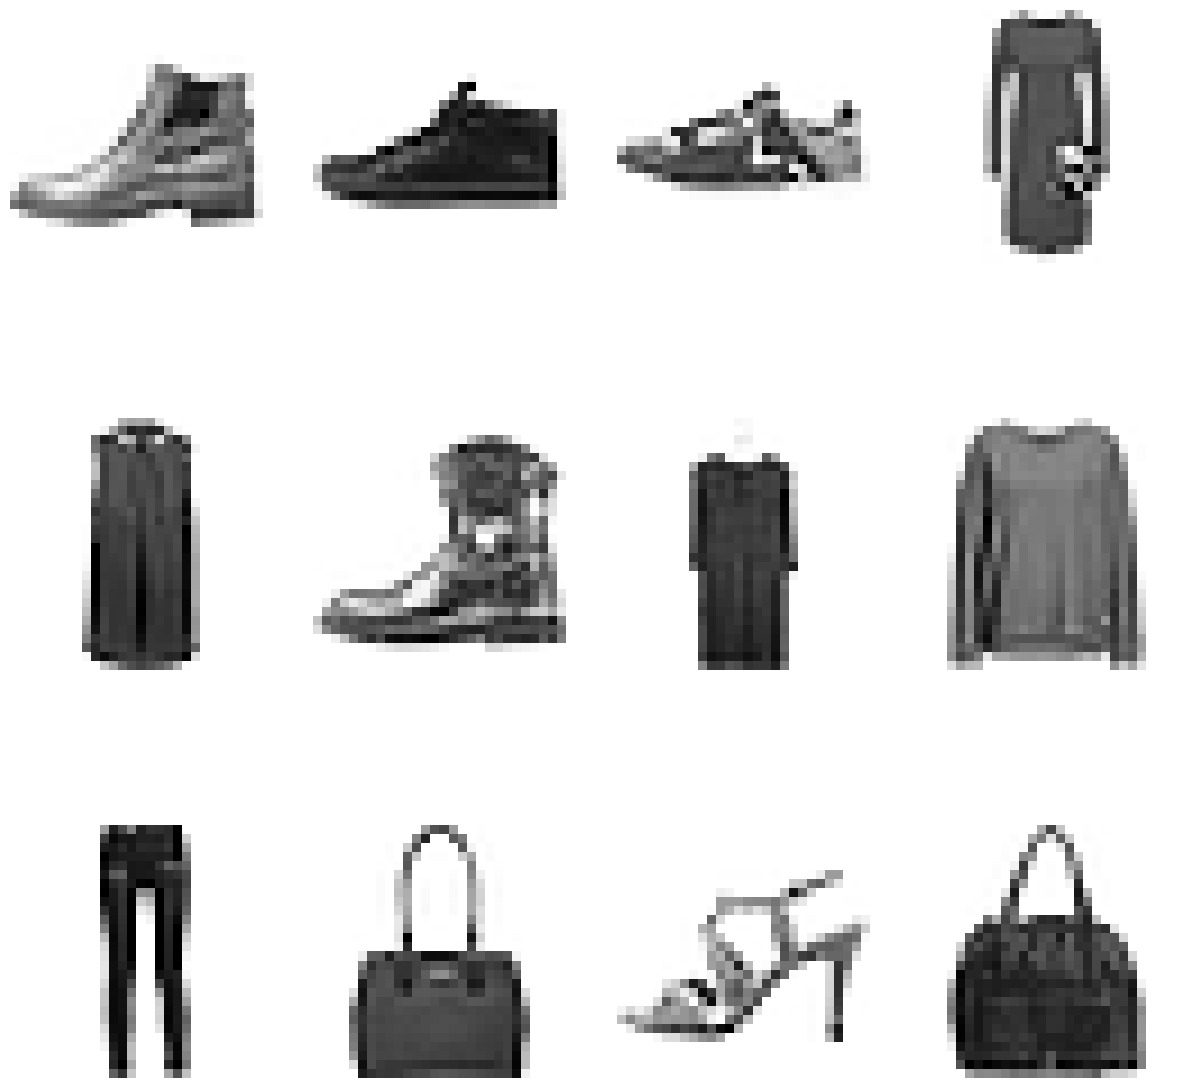

In [13]:
plot_imgs(12, train_ds)

In [9]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64,shuffle=False)
test_loader = DataLoader(train_ds, batch_size=64, shuffle=False)

# Checke Label-Verteilung

In [10]:
from collections import Counter

cntr = Counter()
total = 0
for _, labels in train_loader:
    total += labels.shape[0]
    cntr.update(labels.tolist())

cntr
for label, count in cntr.items():
    print(f"Label {label}: {count/total:.3f}")

Label 3: 0.100
Label 7: 0.101
Label 0: 0.099
Label 6: 0.100
Label 1: 0.099
Label 2: 0.100
Label 5: 0.101
Label 9: 0.100
Label 8: 0.100
Label 4: 0.100


In [14]:
def accuracy_fn(model, dataloader):
    correct = 0
    total = 0
    model = model.eval()
    for features, labels in dataloader:
        with torch.inference_mode():
            logits = model(features)
        y_pred = torch.argmax(logits, dim=1)
        compare = labels == y_pred
        correct += torch.sum(compare)
        total += len(compare)
    return correct/total

In [15]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=64, hidden_layers = 2):
        super().__init__()
        layers = [nn.Linear(in_features=in_features, out_features=hidden_units), nn.ReLU()]
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
        layers.append(nn.Linear(hidden_units, out_features))

        self.stack = nn.Sequential(
            *layers
        )
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.stack(x)

In [23]:
import torch.nn.functional as F

mlp = MLP(in_features=28*28, out_features=10, hidden_units=64, hidden_layers=2)
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=0.01)

history = {
    "train_losses": [],
    "train_accs": [],
    "val_accs": []
}

epochs = 15
for epoch in range(epochs):

    mlp = mlp.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        logits = mlp(features)

        train_loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()

        train_loss.backward()
        optimizer.step()
        history["train_losses"].append(train_loss.detach())

        # if batch_idx%400 == 0:
        #     train_acc = accuracy_fn(mlp, train_loader)
        #     test_acc = accuracy_fn(mlp, val_loader)

        #     history["train_accs"].append(train_acc.detach())
        #     history["val_accs"].append(test_acc.detach())
        #     print(f"Batch {batch_idx}: {train_loss}")
    train_acc = accuracy_fn(mlp, train_loader)
    test_acc = accuracy_fn(mlp, val_loader)

    history["train_accs"].append(train_acc.detach())
    history["val_accs"].append(test_acc.detach())

    print(f"Epoch: {epoch+1}/{epochs} | Train acc: {history['train_accs'][-1]:.3f} |  Val acc: {history['val_accs'][-1]:.3f}")


Epoch: 1/15 | Train acc: 0.850 |  Val acc: 0.844
Epoch: 2/15 | Train acc: 0.858 |  Val acc: 0.847
Epoch: 3/15 | Train acc: 0.861 |  Val acc: 0.851
Epoch: 4/15 | Train acc: 0.863 |  Val acc: 0.850
Epoch: 5/15 | Train acc: 0.874 |  Val acc: 0.865
Epoch: 6/15 | Train acc: 0.867 |  Val acc: 0.852
Epoch: 7/15 | Train acc: 0.873 |  Val acc: 0.860
Epoch: 8/15 | Train acc: 0.872 |  Val acc: 0.855
Epoch: 9/15 | Train acc: 0.873 |  Val acc: 0.858
Epoch: 10/15 | Train acc: 0.884 |  Val acc: 0.865
Epoch: 11/15 | Train acc: 0.882 |  Val acc: 0.864
Epoch: 12/15 | Train acc: 0.883 |  Val acc: 0.866
Epoch: 13/15 | Train acc: 0.876 |  Val acc: 0.859
Epoch: 14/15 | Train acc: 0.876 |  Val acc: 0.856
Epoch: 15/15 | Train acc: 0.883 |  Val acc: 0.864


(0.0, 1.0)

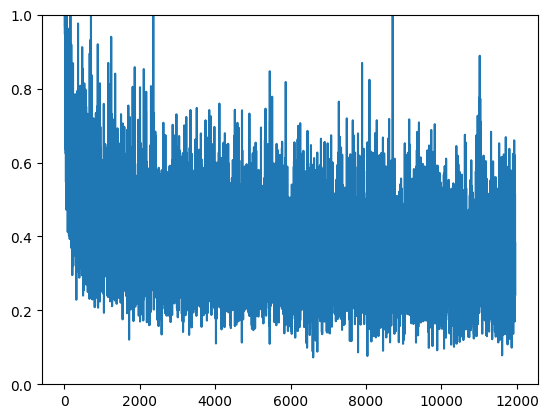

In [24]:
plt.plot(history["train_losses"])
plt.ylim((0,1))

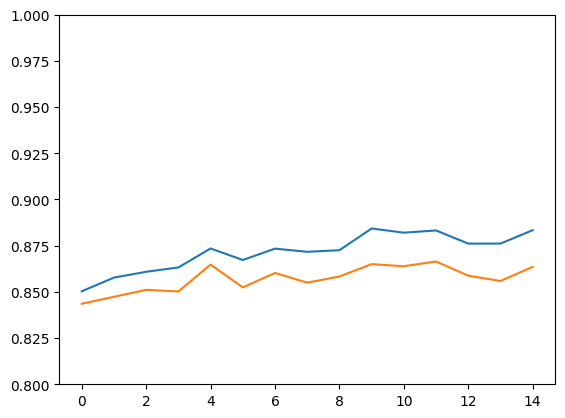

In [25]:
plt.plot(history["train_accs"])
plt.plot(history["val_accs"])
plt.ylim((0.8,1));

In [26]:
accuracy_fn(mlp, test_loader)

tensor(0.8834)

In [22]:
sum([p.numel() for p in mlp.parameters()])

59210